<a href="https://colab.research.google.com/github/JunhOpportunity/AI_lab/blob/main/week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cuda device


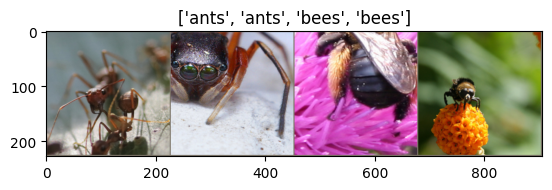

Epoch 0/24
----------
train Loss: 0.6336 Acc: 0.6885
val Loss: 0.2877 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.6006 Acc: 0.7705
val Loss: 1.0002 Acc: 0.6797

Epoch 2/24
----------
train Loss: 0.7346 Acc: 0.7582
val Loss: 0.9157 Acc: 0.8105

Epoch 3/24
----------
train Loss: 0.5203 Acc: 0.8238
val Loss: 0.2459 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4578 Acc: 0.8484
val Loss: 0.2148 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.6695 Acc: 0.7418
val Loss: 0.4980 Acc: 0.7974

Epoch 6/24
----------
train Loss: 0.5865 Acc: 0.7787
val Loss: 0.3898 Acc: 0.8431

Epoch 7/24
----------
train Loss: 0.2803 Acc: 0.8730
val Loss: 0.2502 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3283 Acc: 0.8607
val Loss: 0.3355 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.4108 Acc: 0.8238
val Loss: 0.2818 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.2827 Acc: 0.8648
val Loss: 0.2390 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3232 Acc: 0.8689
val Loss: 0.2239 Acc: 0.9412

Ep

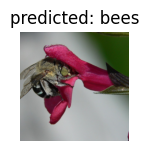

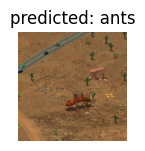

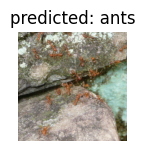

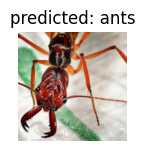

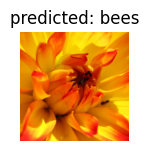

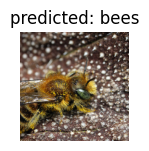

Epoch 0/24
----------
train Loss: 0.7110 Acc: 0.6270
val Loss: 0.5719 Acc: 0.6797

Epoch 1/24
----------
train Loss: 0.6392 Acc: 0.7172
val Loss: 0.1970 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4231 Acc: 0.8156
val Loss: 0.2164 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4824 Acc: 0.8197
val Loss: 0.1734 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4156 Acc: 0.8156
val Loss: 0.4729 Acc: 0.8039

Epoch 5/24
----------
train Loss: 0.6813 Acc: 0.7500
val Loss: 0.2080 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4597 Acc: 0.7992
val Loss: 0.1830 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3969 Acc: 0.8115
val Loss: 0.1778 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3759 Acc: 0.8607
val Loss: 0.1707 Acc: 0.9673

Epoch 9/24
----------
train Loss: 0.3599 Acc: 0.8361
val Loss: 0.1661 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3323 Acc: 0.8525
val Loss: 0.2149 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2972 Acc: 0.8689
val Loss: 0.1719 Acc: 0.9542

Ep

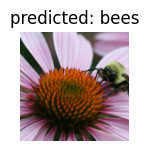

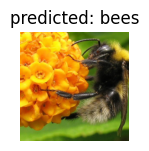

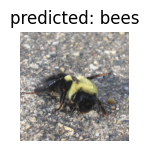

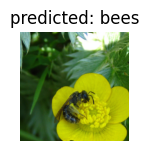

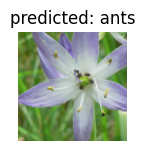

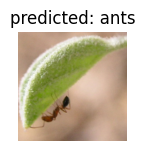

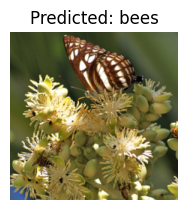

In [9]:
# License: BSD
# Author: Sasank Chilamkurthy
import zipfile
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

# 압축 파일 경로와 풀 경로 지정
zip_path = '/content/hymenoptera_data.zip'
extract_path = 'output_folder'

# 폴더가 없으면 생성
os.makedirs(extract_path, exist_ok=True)

# ZIP 파일 열기 및 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load DATA
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'output_folder/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv)

plt.ioff()
plt.show()

def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


visualize_model_predictions(
    model_conv,
    img_path='/content/output_folder/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

Using cuda device


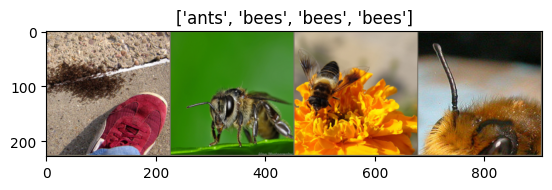

Epoch 0/24
----------
train Loss: 3.6490 Acc: 0.4016
val Loss: 1.9693 Acc: 0.6405

Epoch 1/24
----------
train Loss: 0.5372 Acc: 0.7705
val Loss: 0.7725 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.4627 Acc: 0.7746
val Loss: 1.5033 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.4604 Acc: 0.8033
val Loss: 1.0651 Acc: 0.7908

Epoch 4/24
----------
train Loss: 0.3517 Acc: 0.8689
val Loss: 0.8160 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.3645 Acc: 0.8566
val Loss: 0.5688 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.3634 Acc: 0.8607
val Loss: 0.4580 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3369 Acc: 0.8484
val Loss: 0.3519 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3781 Acc: 0.8525
val Loss: 0.4806 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.3694 Acc: 0.8320
val Loss: 0.4902 Acc: 0.8693

Epoch 10/24
----------
train Loss: 0.3320 Acc: 0.8566
val Loss: 0.4531 Acc: 0.8693

Epoch 11/24
----------
train Loss: 0.3161 Acc: 0.8607
val Loss: 0.4136 Acc: 0.8824

Ep

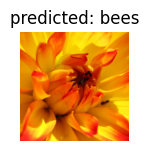

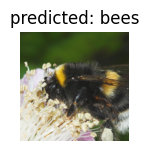

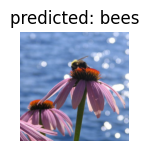

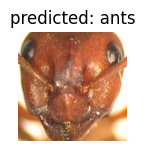

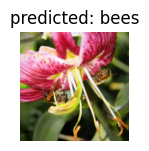

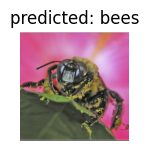

Epoch 0/24
----------
train Loss: 0.6101 Acc: 0.7049
val Loss: 0.2571 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5160 Acc: 0.7787
val Loss: 0.4394 Acc: 0.8105

Epoch 2/24
----------
train Loss: 0.4029 Acc: 0.8197
val Loss: 0.1856 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.5137 Acc: 0.7787
val Loss: 0.5193 Acc: 0.7647

Epoch 4/24
----------
train Loss: 0.4108 Acc: 0.8074
val Loss: 0.2150 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4897 Acc: 0.8115
val Loss: 0.1951 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.6538 Acc: 0.7541
val Loss: 0.1904 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3733 Acc: 0.8443
val Loss: 0.1965 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3488 Acc: 0.8402
val Loss: 0.1997 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3311 Acc: 0.8443
val Loss: 0.1820 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3583 Acc: 0.8238
val Loss: 0.1886 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3654 Acc: 0.8484
val Loss: 0.2037 Acc: 0.9542

Ep

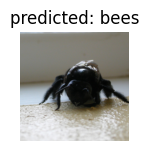

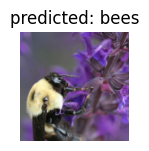

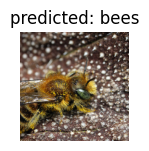

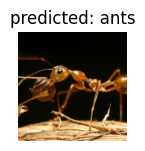

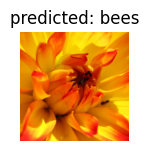

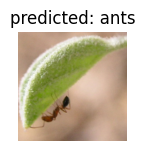

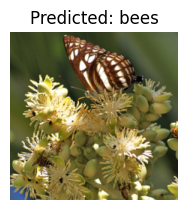

In [10]:
# License: BSD
# Author: Sasank Chilamkurthy
# efficientnet_b3
# 마지막 레이어 입력 차원 가져오기 num_ftrs = model_ft.classifier[1].in_features
import zipfile
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

# 압축 파일 경로와 풀 경로 지정
zip_path = '/content/hymenoptera_data.zip'
extract_path = 'output_folder'

# 폴더가 없으면 생성
os.makedirs(extract_path, exist_ok=True)

# ZIP 파일 열기 및 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load DATA
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'output_folder/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# efficientnet_b3
# 마지막 레이어 입력 차원 가져오기 num_ftrs = model_ft.classifier[1].in_features

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv)

plt.ioff()
plt.show()

def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


visualize_model_predictions(
    model_conv,
    img_path='/content/output_folder/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()
